In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Sequence, Iterable

print(f'np=={np.__version__}')
print(f'pd=={pd.__version__}')
print(f'sns=={sns.__version__}')

/var/folders/69/s6p755q576qb2bbk9bc__tr40000gn/T/ipykernel_61439/3954526969.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


np==1.26.4
pd==2.2.0
sns==0.13.2


### Data Import
---

In [3]:
train_trns = pd.read_csv('/Users/oskarwallberg/desktop/kaggle-datasets/ieee-fraud-detection/train_transaction.csv')
test_trns = pd.read_csv('/Users/oskarwallberg/desktop/kaggle-datasets/ieee-fraud-detection/test_transaction.csv')
train_trns.shape, test_trns.shape

((590540, 394), (506691, 393))

In [4]:
# Visualise NaNs
# plt.figure(figsize=(16, 8))
# sns.heatmap(data=train_trns.isna())
# plt.show()

### Transaction Features
---
* TransactionID     : Transaction unique identifier
* isFraud           : Is or is not fraud (target feature)
* TransactionDT     : Transaction 'Datetime' (more timedelta from reference point)
* TransactionAmt    : Transaction Amount [USD]
* ProductCD         : Product Codes (W, C, R, H, S)
* card1 - card6     : Payment card info, 
* addr1, addr2      : Address
* dist1, dist2      : Distance
* P_emaildomain     : Purchaser email domain
* R_emaildomain     : Reciever email domain
* C1 - C14          : (float) Counting, (e.g. num adresses to be associated with payment card etc, Exact meaning is masked)
* D1 - D15          : (float) Timedelta, (e.g. num days after last transaction)
* M1 - M9           : (object) Match, (e.g. name on card and adress)
* V1 - V339         : (float) Vesta engineered rich features (incl. ranking, counting, other relations)

### Categorical Features - Transaction
---
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

In [5]:
print(train_trns['isFraud'].value_counts())
print(f"is fraud : {np.round(train_trns['isFraud'].sum()/train_trns.shape[0]*100, decimals=2)}%")

isFraud
0    569877
1     20663
Name: count, dtype: int64
is fraud : 3.5%


In [6]:
df_valid = train_trns.loc[train_trns['isFraud'] == 0]
df_fraud = train_trns.loc[train_trns['isFraud'] == 1]
df_valid.shape, df_fraud.shape

((569877, 394), (20663, 394))

In [7]:
# Only 17 transactions larger than 5000 USD (which is about the largest non fraudulent transaction)
# May exclude these (at least when visualising the data)
df_valid.loc[df_valid['TransactionAmt'] > 5000].shape

(17, 394)

In [8]:
print(f"Valid transaction amount mean: {df_valid['TransactionAmt'].mean()}")
print(f"Fraud transaction amount mean: {df_fraud['TransactionAmt'].mean()}")

Valid transaction amount mean: 134.51166457849672
Fraud transaction amount mean: 149.24477858974976


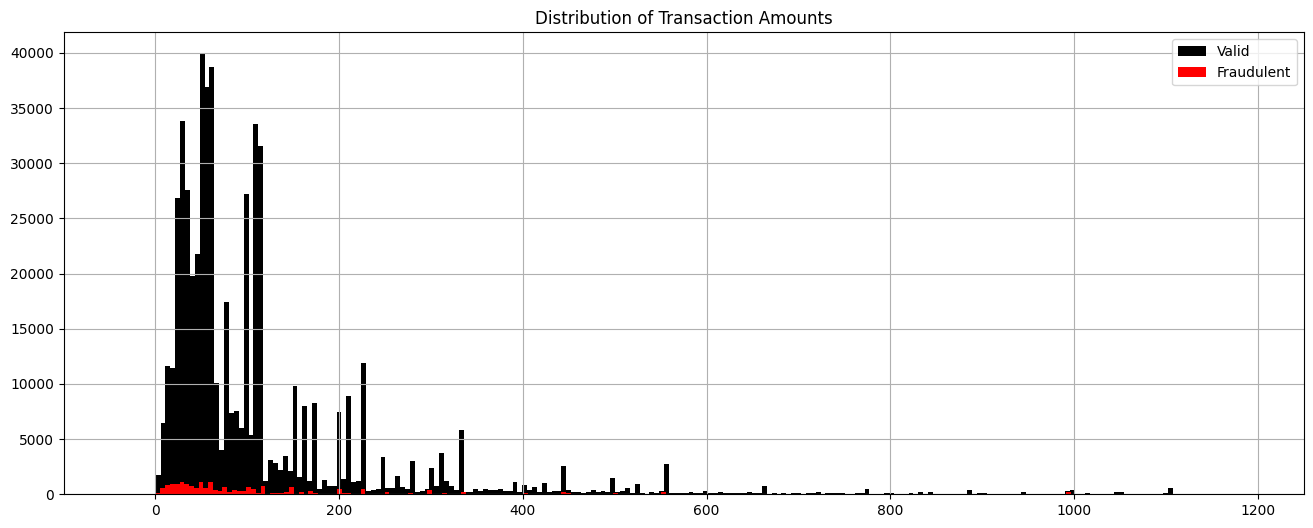

In [9]:
plt.figure(figsize=(16, 6))
plt.xlim(-100, 1250)
plt.title('Distribution of Transaction Amounts')
df_valid['TransactionAmt'].hist(bins=6000, label='Valid', color='k')
df_fraud['TransactionAmt'].hist(bins=1000, label='Fraudulent', color='r')
plt.legend()
plt.show()

In [10]:
# About 182 days (half a year) of recorded transactions assuming TransactionDT is in seconds
sec_in_day = 24*3600
(df_valid['TransactionDT'].max() - df_valid['TransactionDT'].min())/sec_in_day

181.99920138888888

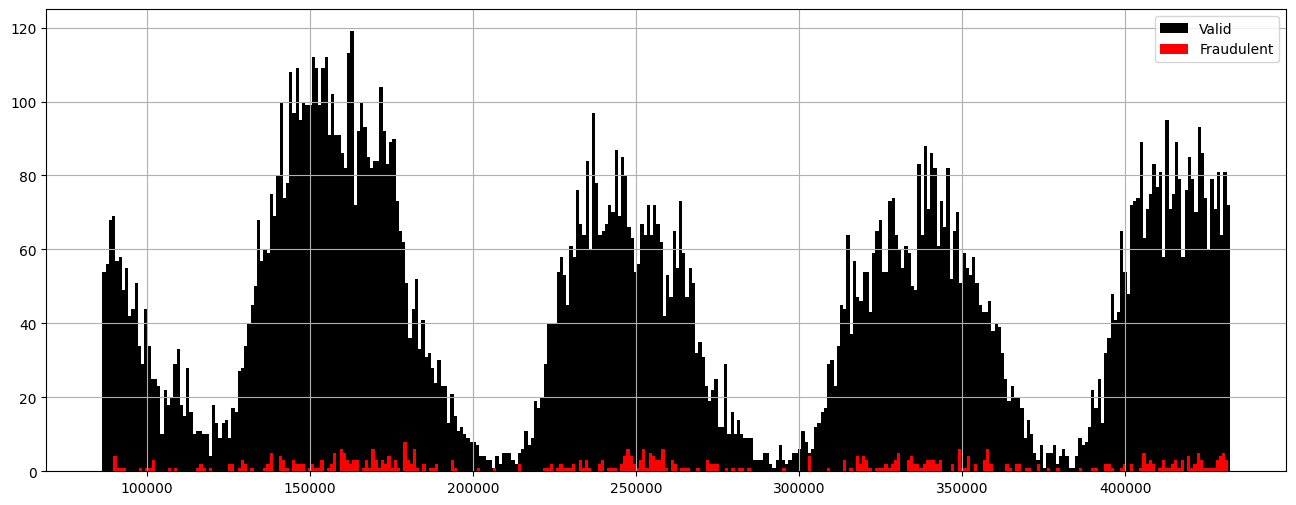

In [11]:
n_days = 5
plt.figure(figsize=(16, 6))
df_valid.loc[df_valid['TransactionDT'] < n_days*sec_in_day, 'TransactionDT'].hist(bins=350, label='Valid', color='k')
df_fraud.loc[df_fraud['TransactionDT'] < n_days*sec_in_day, 'TransactionDT'].hist(bins=350, label='Fraudulent', color='r')
plt.legend()
plt.show()

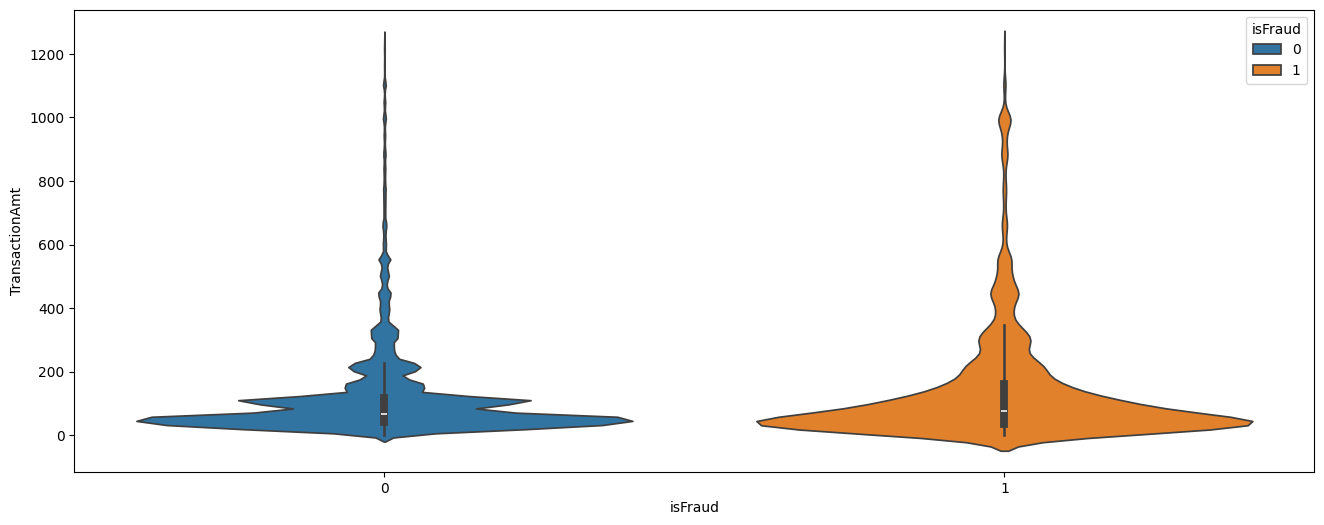

In [12]:
plt.figure(figsize=(16, 6))
sns.violinplot(data=train_trns.loc[train_trns['TransactionAmt'] < 1250], x='isFraud', y='TransactionAmt', hue='isFraud')
plt.show()

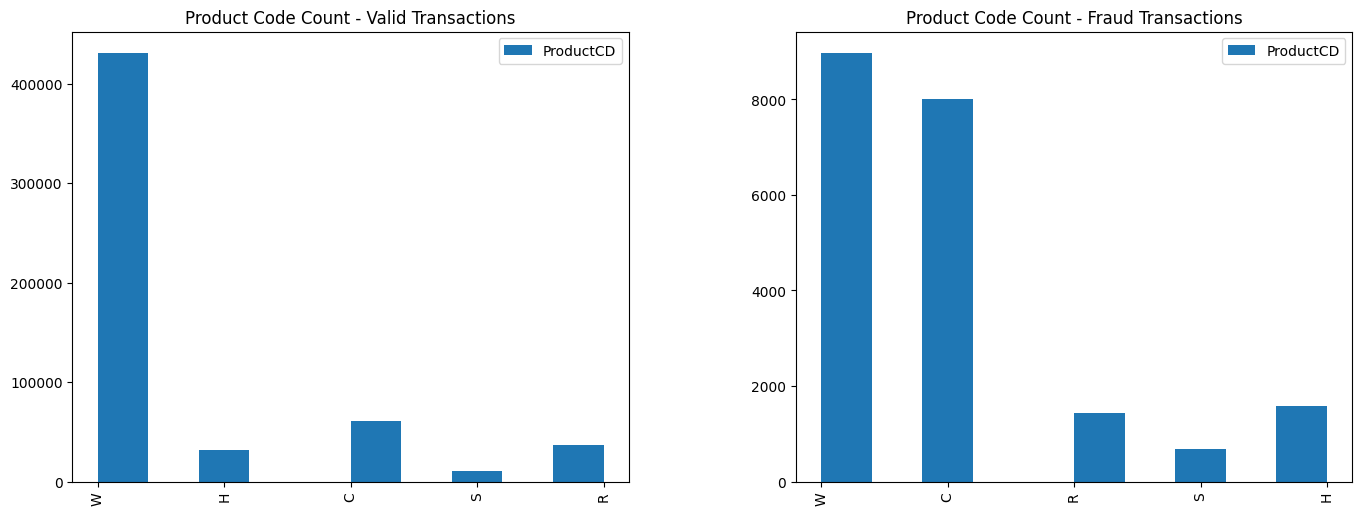

,ProductCD,percentage valid,percentage fraud
0,W,0.755779,0.434061
1,C,0.106183,0.387553
2,R,0.063651,0.069012
3,H,0.055187,0.076175
4,S,0.019201,0.033199


In [13]:
# NOTE New Feature idea : isProdCodeC (if fraud => higher percentage C) (if C higher percentage of seeing fraud then for other product codes)
product_code_percentages_valid = (df_valid['ProductCD'].value_counts()/df_valid.shape[0]).rename('percentage valid')
product_code_percentages_fraud = (df_fraud['ProductCD'].value_counts()/df_fraud.shape[0]).rename('percentage fraud')
df_prodcodes = pd.merge(
    left=product_code_percentages_valid, 
    right=product_code_percentages_fraud, 
    left_index=True, right_index=True
    ).reset_index()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
train_trns.hist(ax=axes, by='isFraud', column='ProductCD', legend=True)
axes[0].set_title('Product Code Count - Valid Transactions')
axes[1].set_title('Product Code Count - Fraud Transactions')
plt.show()

df_prodcodes

#### Transaction Features
---
* TransactionID     : Transaction unique identifier
* isFraud           : Is or is not fraud (target feature)
* TransactionDT     : Transaction 'Datetime' (more timedelta from reference point)
* TransactionAmt    : Transaction Amount [USD]
* ProductCD         : Product Codes (W, C, R, H, S)
* card1 - card6     : Payment card info,                        card1 is main UID
* addr1, addr2      : Address                                   addr1 is main UID
* dist1, dist2      : Distance                                  UNCLEAR
* P_emaildomain     : Purchaser email domain                    email domain like gmail.com or yahoo.com etc...
* R_emaildomain     : Reciever email domain                     -//-
* C1 - C14          : (float) Counting, (e.g. num adresses to be associated with payment card etc, Exact meaning is masked)     NO NULL VALUES!!
* D1 - D15          : (float) Timedelta, (e.g. num days after last transaction)                                                 NULLS
* M1 - M9           : (object) Match, (e.g. name on card and adress)                                                            NULLS

#### Categorical Features - Transaction
---
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

In [80]:
# train_trns[[f"card{i}" for i in range(1, 7)]][["card1"]].value_counts().shape[0]

train_trns[["dist1", "dist2"]+['isFraud']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dist1    238269 non-null  float64
 1   dist2    37627 non-null   float64
 2   isFraud  590540 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 13.5 MB


In [36]:
train_trns.shape[0]

590540

In [ ]:
# V_COLS = ['V'+str(n) for n in range(1, 340)]

# def plot_vesta_feature(v_cols: Sequence[float], n_plots:int=None):
#     if n_plots is None: n_plots = len(v_cols)

#     plt.figure(figsize=(16, n_plots*4))
#     gs = plt.GridSpec(nrows=n_plots, ncols=1)
    
#     for i, v_col in enumerate(v_cols[:n_plots]):
#         ax = plt.subplot(gs[i])
#         # ax.set_xlim(-500, 1000)
#         sns.histplot(ax=ax, data=df_valid[v_col], kde=True, bins=100)
#         sns.histplot(ax=ax, data=df_fraud[v_col], kde=True, bins=100)
#         # sns.kdeplot(ax=ax, data=df_valid[v_col], warn_singular=False)
#         # sns.kdeplot(ax=ax, data=df_fraud[v_col], warn_singular=False)

#     plt.show()

In [ ]:
# EPSILON = 1/(2*train_trns.shape[0])     # 1 in 2*len(data) to see unseen value... reasonable?

# # Calculate the Kullback Leibler Divergence (KL-div) between fraud and valid Vesta Engineered (V)-features
# def kl_divergence(P:pd.Series, Q:pd.Series) -> float:
#     union_index = np.union1d(ar1=P.index, ar2=Q.index)
#     kl_div = 0

#     for i in union_index:
#         p = P.get(key=i, default=EPSILON)
#         q = Q.get(key=i, default=EPSILON)
#         kl_div += p * np.log(p/q)
#     return kl_div

In [ ]:

# df_kl = pd.DataFrame(data={
#     'v_col': V_COLS,
# })

# kl_divs = np.zeros_like(V_COLS, dtype=np.float64)

# for i, v_col in enumerate(V_COLS):
#     counts_fraud = df_fraud[v_col].value_counts().sort_index()
#     P_frd = counts_fraud / counts_fraud.sum()
#     counts_valid = df_valid[v_col].value_counts().sort_index()
#     Q_vld = counts_valid / counts_valid.sum()

#     assert np.isclose(a=P_frd.sum(), b=1.0, rtol=1e-5), 'Invalid P distribution. Must sum to 1.'
#     assert np.isclose(a=Q_vld.sum(), b=1.0, rtol=1e-5), 'Invalid Q distribution. Must sum to 1.'

#     kl_divs[i] = kl_divergence(P=P_frd, Q=Q_vld)

# df_kl['kl_div'] = kl_divs
# df_kl.shape

(339, 2)

In [81]:
# df_kl = df_kl.sort_values(by='kl_div', ascending=False)
# df_kl.head(n=20)['v_col']

In [82]:
# plot_vesta_feature(v_cols=df_kl.head(n=20)['v_col'])